In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.math import confusion_matrix

In [2]:
DATA_PATH = "../../ui-application/data_exports"

In [3]:
GESTURES = [
    "rub_palms",
    "palm_over_dorsum_left",
    "palm_over_dorsum_right",
    "palm_to_palm_fingers",
    "fingers_interlocked",
    "thumb_rub_left",
    "thumb_rub_right",
    "palms_with_fingers_left",
    "palms_with_fingers_right",
    "misc",
]

# Visualize Data

In [4]:
df_arr = [pd.read_csv(f"{DATA_PATH}/{guesture}.csv") for guesture in GESTURES]
tuple(map(lambda df: print(df.info()), df_arr))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3571 entries, 0 to 3570
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   aX      3571 non-null   float64
 1   aY      3571 non-null   float64
 2   aZ      3571 non-null   float64
 3   gX      3571 non-null   float64
 4   gY      3571 non-null   float64
 5   gZ      3571 non-null   float64
dtypes: float64(6)
memory usage: 167.5 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3571 entries, 0 to 3570
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   aX      3571 non-null   float64
 1   aY      3571 non-null   float64
 2   aZ      3571 non-null   float64
 3   gX      3571 non-null   float64
 4   gY      3571 non-null   float64
 5   gZ      3571 non-null   float64
dtypes: float64(6)
memory usage: 167.5 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3571 entries, 0 to 3570
Data columns (total 6 column

(None, None, None, None, None, None, None, None, None, None, None)

In [5]:
def plot_dataset(guesture_index, start, width, df_arr=df_arr, guestures=GESTURES):
    guesture, df = guestures[guesture_index], df_arr[guesture_index][start : start+width]
    df_index = np.arange(start, start+width)
    fig, ax = plt.subplots(1,2,figsize=(20,5))
    
    ax[0].plot(df_index, df['gX'], 'g', label='X')
    ax[0].plot(df_index, df['gY'], 'b', label='Y')
    ax[0].plot(df_index, df['gZ'], 'r', label='Z')
    ax[0].set_title("Gyroscope")
    ax[0].set_xlabel("Sample #")
    ax[0].set_ylabel("Gyroscope (deg/sec)")
    ax[0].legend()
    
    ax[1].plot(df_index, df['aX'], 'g', label='X')
    ax[1].plot(df_index, df['aY'], 'b', label='Y')
    ax[1].plot(df_index, df['aZ'], 'r', label='Z')
    ax[1].set_title("Acceleration")
    ax[1].set_xlabel("Sample #")
    ax[1].set_ylabel("Acceleration (G)")
    ax[1].legend()

    plt.suptitle(f"Readings of {guesture}")
    plt.show()

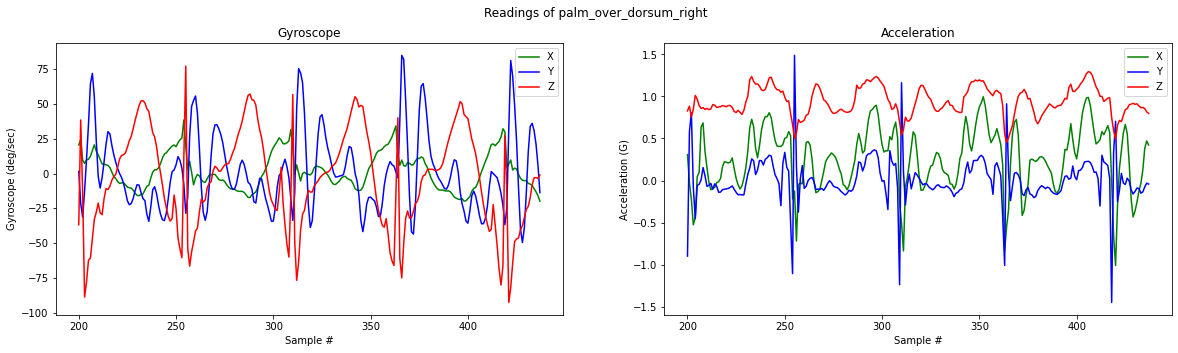

In [6]:
plot_dataset(3, 200, 119*2)

In [7]:
max_vals = np.array(tuple(map(lambda df: (df["aX"].max(), df["aY"].max(), df["aZ"].max(), df["gX"].max(), df["gY"].max(), df["gZ"].max(),),df_arr))).max(axis=0)
min_vals = np.array(tuple(map(lambda df: (df["aX"].min(), df["aY"].min(), df["aZ"].min(), df["gX"].min(), df["gY"].min(), df["gZ"].min(),),df_arr))).min(axis=0)

print(f"max_vals: {max_vals}\nmin_vals: {min_vals}")

max_vals: [  3.05    1.788   1.892  93.567 692.261 135.315]
min_vals: [  -1.557   -2.22    -1.793 -137.878 -566.528 -112.427]


Acceleration range: (-1.793, 3.05)\
Angular rotation range: (-566, 692)\
Assuming the range for acceleration: (-4, 4)\
Assuming the range for angular rotation: (-1000, 1000)

# Create the Dataset

In [4]:
# Constants
SAMPLE_RATE = 119 # <-- Fixed sample rate of the Arduino Nano 33 BLE IMU (Hz)

NUM_GESTURES = len(GESTURES)
NUM_SENSORS = 6

In [5]:
def create_dataset(shift=1, sensor_width=SAMPLE_RATE, guestures=GESTURES, data_path=DATA_PATH, normalize_parameters={"a":(-4, 4), "g":(-1000, 1000)}, shuffle=True):
    
    a_min, a_max = normalize_parameters["a"]
    g_min, g_max = normalize_parameters["g"]

    df_arr = [pd.read_csv(f"{data_path}/{guesture}.csv") for guesture in guestures]
    # normalize the dfs
    for df in df_arr:
        df["aX"], df["aY"], df["aZ"] = (df["aX"]-a_min)/(a_max-a_min), (df["aY"]-a_min)/(a_max-a_min), (df["aZ"]-a_min)/(a_max-a_min)
        df["gX"], df["gY"], df["gZ"] = (df["gX"]-g_min)/(g_max-g_min), (df["gY"]-g_min)/(g_max-g_min), (df["gZ"]-g_min)/(g_max-g_min)
        df.clip(0, 1, inplace=True)
        
    example_width = sensor_width*NUM_SENSORS

    df_lens = tuple(map(lambda df: df.shape[0], df_arr))
    example_counts = tuple(map(lambda len: (len-example_width)//shift, df_lens))
    example_total_count = sum(example_counts)

    X = np.zeros((example_total_count, example_width))
    Y = np.zeros((example_total_count, NUM_GESTURES))

    index_shift = 0
    for df_index, (df, example_count) in enumerate(zip(df_arr, example_counts)):
        Y[index_shift:index_shift+example_count, df_index] = 1
        for example_index in range(example_count):
            X[example_index+index_shift][0::6] = df.iloc[:,0][example_index*shift:sensor_width+example_index*shift]
            X[example_index+index_shift][1::6] = df.iloc[:,1][example_index*shift:sensor_width+example_index*shift]
            X[example_index+index_shift][2::6] = df.iloc[:,2][example_index*shift:sensor_width+example_index*shift]
            X[example_index+index_shift][3::6] = df.iloc[:,3][example_index*shift:sensor_width+example_index*shift]
            X[example_index+index_shift][4::6] = df.iloc[:,4][example_index*shift:sensor_width+example_index*shift]
            X[example_index+index_shift][5::6] = df.iloc[:,5][example_index*shift:sensor_width+example_index*shift]
        index_shift += example_count

    if shuffle:
        randomize = np.arange(example_total_count)
        np.random.shuffle(randomize)
        X, Y = X[randomize], Y[randomize]

    return X, Y, example_total_count

In [8]:
X, Y, m = create_dataset()

In [9]:
def visualize_dataset(index, X=X, Y=Y, sensor_width=SAMPLE_RATE, gestures=GESTURES):
    x, y = X[index], Y[index]

    print(f"Gesture name: {gestures[y.argmax()]}\nGuesture #: {y.argmax()}")
    
    x_axis = np.arange(x.size//NUM_SENSORS)
    fig, ax = plt.subplots(1,2,figsize=(20,5))
    
    ax[0].plot(x_axis, x[0::6], 'g', label='X')
    ax[0].plot(x_axis, x[1::6], 'b', label='Y')
    ax[0].plot(x_axis, x[2::6], 'r', label='Z')
    ax[0].set_title("Acceleration")
    ax[0].set_xlabel("Sample #")
    ax[0].set_ylabel("Acceleration (G)")
    ax[0].legend()
    
    ax[1].plot(x_axis, x[3::6], 'g', label='X')
    ax[1].plot(x_axis, x[4::6], 'b', label='Y')
    ax[1].plot(x_axis, x[5::6], 'r', label='Z')
    ax[1].set_title("Gyroscope")
    ax[1].set_xlabel("Sample #")
    ax[1].set_ylabel("Gyroscope (deg/sec)")
    ax[1].legend()

    plt.show()

Gesture name: fingers_interlocked
Guesture #: 4


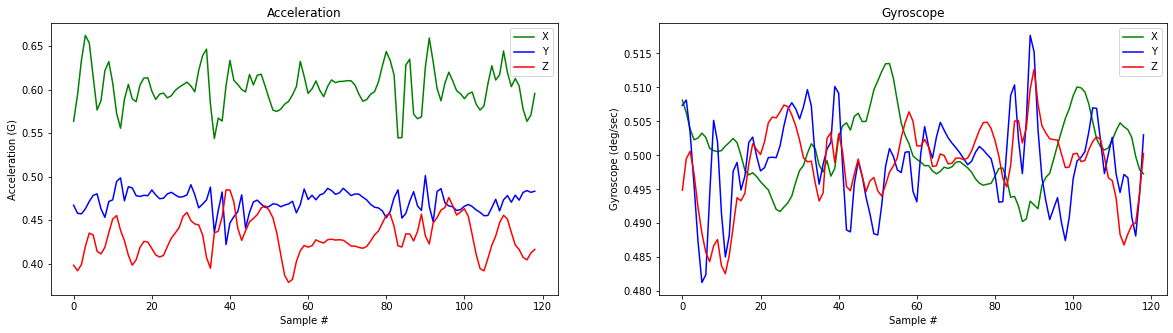

In [10]:
visualize_dataset(10)

In [11]:
# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * m)
TEST_SPLIT = int(0.2 * m + TRAIN_SPLIT)

x_train, x_test, x_validate = np.split(X, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(Y, [TRAIN_SPLIT, TEST_SPLIT])

print(len(x_train), len(x_test), len(x_validate))

print("Data set randomization and splitting complete.")

38562 12854 12854
Data set randomization and splitting complete.


# Model

In [12]:
# build the model and train it
def create_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(64, activation='relu')) # relu is used for performance
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input

    return model

model = create_model()
mcp_save = ModelCheckpoint('./checkpoints/mdl_60s_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'accuracy'])

In [13]:
history = model.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_validate, y_validate), callbacks=[mcp_save])

Epoch 1/100
2411/2411 [==============================] - 13s 5ms/step - loss: 0.0354 - mae: 0.0821 - accuracy: 0.7405 - val_loss: 0.0125 - val_mae: 0.0363 - val_accuracy: 0.9317
Epoch 2/100
2411/2411 [==============================] - 12s 5ms/step - loss: 0.0128 - mae: 0.0320 - accuracy: 0.9184 - val_loss: 0.0085 - val_mae: 0.0232 - val_accuracy: 0.9504
Epoch 3/100
2411/2411 [==============================] - 11s 5ms/step - loss: 0.0114 - mae: 0.0254 - accuracy: 0.9254 - val_loss: 0.0080 - val_mae: 0.0192 - val_accuracy: 0.9504
Epoch 4/100
2411/2411 [==============================] - 11s 4ms/step - loss: 0.0112 - mae: 0.0232 - accuracy: 0.9268 - val_loss: 0.0090 - val_mae: 0.0198 - val_accuracy: 0.9392
Epoch 5/100
2411/2411 [==============================] - 11s 4ms/step - loss: 0.0110 - mae: 0.0219 - accuracy: 0.9280 - val_loss: 0.0083 - val_mae: 0.0172 - val_accuracy: 0.9447
Epoch 6/100
2411/2411 [==============================] - 10s 4ms/step - loss: 0.0108 - mae: 0.0208 - accuracy:

In [14]:
# model = create_model()
best_model = tf.keras.models.load_model('./checkpoints/mdl_60s_wts.hdf5')

# Evaluation

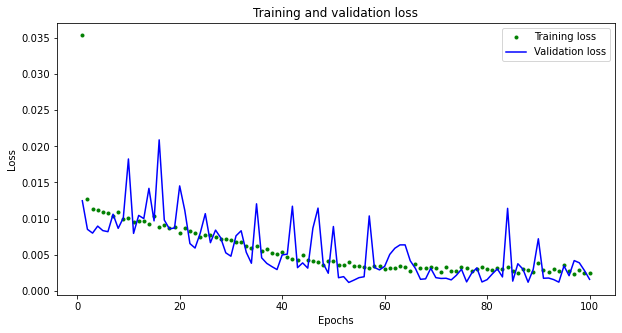

In [15]:
# increase the size of the graphs. The default size is (6,4).
plt.figure(figsize=(10,5))

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

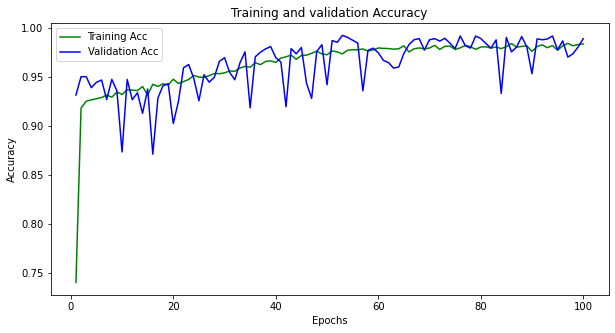

In [16]:
# graph of mean absolute error
plt.figure(figsize=(10,5))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
# use the model to predict the test inputs
predictions = model.predict(x_test)
pred_indices = predictions.argmax(axis=1)
labl_indices = y_test.argmax(axis=1)

conf_mat = confusion_matrix(labl_indices, pred_indices)
conf_mat

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[1310,    0,    0,   37,    0,    0,    0,    0,    0,    0],
       [   0, 1306,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 1279,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 1259,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1291,    0,    0,    0,    0,    0],
       [   0,   26,    0,    0,    0, 1289,    1,    0,    0,    0],
       [   0,    2,    0,    0,    0,   62, 1200,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 1233,    0,    0],
       [   0,    0,    0,    0,    5,    0,    0,    0, 1271,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 1283]])>

In [18]:
# use the model to predict the test inputs
predictions = best_model.predict(x_test)
pred_indices = predictions.argmax(axis=1)
labl_indices = y_test.argmax(axis=1)

conf_mat = confusion_matrix(labl_indices, pred_indices)
conf_mat

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[1327,    0,    0,   20,    0,    0,    0,    0,    0,    0],
       [   0, 1306,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 1279,    0,    0,    0,    0,    0,    0,    0],
       [   4,    0,    0, 1255,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1291,    0,    0,    0,    0,    0],
       [   0,    1,    0,    0,    0, 1285,   30,    0,    0,    0],
       [   0,    0,    0,    0,    0,   42, 1222,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 1233,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 1276,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 1283]])>

## Convert the model

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

# Save the model to disk
with open("./tflite/hand_wash_model_60s.tflite", "wb") as handler:
  handler.write(tflite_model)

import os
basic_model_size = os.path.getsize("./tflite/hand_wash_model_60s.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: C:\Users\Avishka\AppData\Local\Temp\tmpymthmr3_\assets


Model is 196336 bytes


In [ ]:
!echo "const unsigned char model[] = {" > tflite/model.h
!cat ./tflite/hand_wash_model.tflite | xxd -i      >> tflite/model.h
!echo "};"                              >> tflite/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")